### Try out tensorflow - lstm in this notebook

In [11]:
### Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import tensorflow.keras.backend as K

#### Approach
- clean data by 
- 3 features first
- choose ~5 features later
- choose value to predict


In [59]:
# Get a random dataset to train from the data we cleaned
path = "./data/traindata/T11_set0.pickle"
df = pd.read_pickle(path)

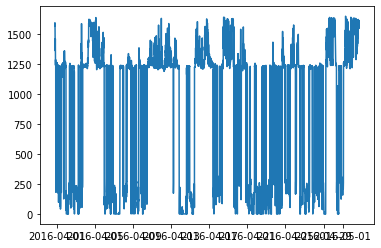

In [60]:
plt.plot(df.Gen_RPM_Min)
#mask_rpm_max = df.Gen_RPM_Max> 1000
mask_rpm_min = df.Gen_RPM_Min> 1000
final_mask = mask_rpm_min #& mask2 & mask3

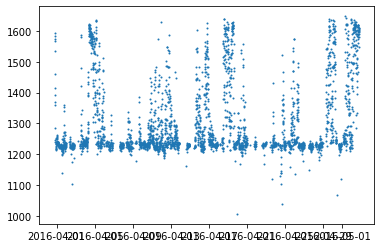

In [61]:
plt.scatter(df.index[mask_rpm_min],df.Gen_RPM_Min[mask_rpm_min],s=1)

In [62]:
# We want to split data at the idling state 
def split_data(mask_in):
    """
    Takes a mask and divides into masks of coherent "True" sections. returns a np.nd array

    """
    l = len(mask_in)
    n=0 # start at value n
    i= 0
    end = False
    mask_list = []
    breakpoint()
    while end==False: # loop as long as the iterator didn't get to the end of the data
        if mask_in[i] == False:
            i +=1
            if i >=l:
                end= True
        else:
            not_found = True
            mask = [False]*l
            while not_found == True:
                mask[i]  = True
                i +=1
                if i >=l: # break inner loop
                    end= True
                    not_found= False
                else:
                    not_found = mask_in[i] # check for the new value  # break outer loop
            mask_list.append(mask)

    return mask_list    

# Testing if fucntion works as intended
a = [True,True,False,False,True,True,False,False]
split_data(a)

[[True, True, False, False, False, False, False, False],
 [False, False, False, False, True, True, False, False]]

In [70]:
# Now we can use it to split all the data.
# Specify a data set lenght we want to keep, like a length or time delta
minimum_data_length = 120 # 2h of data.... we need to calc autocorrelation for the time scales in the data to see if that is enough
coherent_samples = split_data(final_mask)
print(f"Coherent series: {len(coherent_samples)}")
long_samples = [mask_cur for mask_cur in coherent_samples if sum(mask_cur)>minimum_data_length]
print(f"Amount of long samples:{len(long_samples)}") # see if the amount of long coherent samples is sufficient

Coherent series: 144
Amount of long samples:6


### create training dataset
- clean columns time and turbID
- normalize 
- drop index 

In [ ]:
#choose some data

In [64]:
df.columns

Index(['Turbine_ID', 'Timestamp', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Hyd_Oil_Temp_Avg',
       'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg',
       'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Amb_WindSpeed_Max',
       'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std',
       'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg',
       'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
       'Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_TotActPwr',
       'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1',
       'Prod_LatestAvg_ReactPwrGen2', 'Prod_LatestAvg_TotReactPwr',
       'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg',
       'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg',
       'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg',
       'Gen_SlipRing_Temp_Avg', 'Spin

In [84]:
df = df.drop(["Turbine_ID","Timestamp"], axis='columns')

In [85]:
# Trying to predict gen phase 3 from 1 and 2 
columns_in = ["Gen_Phase1_Temp_Avg","Gen_Phase2_Temp_Avg"]
columns_out=["Gen_Phase3_Temp_Avg"]
train_data = df[columns_in][long_samples[0]]
pred_data = df[columns_out][long_samples[0]]

In [123]:
relevant_features = ['Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std',
                     'Gen_Bear_Temp_Avg',
                     'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg',
                     'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
                     'Prod_LatestAvg_TotActPwr',
                     'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1',
                     'Prod_LatestAvg_TotReactPwr',
                     'Gen_SlipRing_Temp_Avg']

#plt.matshow(np.corrcoef(df[long_samples[0]].iloc[:,0:10].T), 0)
current_df = df[long_samples[0]][relevant_features]
#plt.matshow(np.corrcoef(df[long_samples[0]][relevant_features].T), 0)
#df.columns[1]
#print(df[relevant_features])
#print(df.columns[11])

current_df.corr()

,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Prod_LatestAvg_ActPwrGen0,Prod_LatestAvg_ActPwrGen1,Prod_LatestAvg_TotActPwr,Prod_LatestAvg_ReactPwrGen0,Prod_LatestAvg_ReactPwrGen1,Prod_LatestAvg_TotReactPwr,Gen_SlipRing_Temp_Avg
Gen_RPM_Max,1.000000,0.768471,0.938565,0.278684,0.681377,0.775980,0.771477,0.772097,0.181693,0.871511,0.871528,0.181783,-0.926340,-0.926311,0.734088
Gen_RPM_Min,0.768471,1.000000,0.891050,-0.370158,0.817802,0.883715,0.875146,0.874422,0.095446,0.957183,0.957177,0.095680,-0.861824,-0.861987,0.861874
Gen_RPM_Avg,0.938565,0.891050,1.000000,0.011475,0.744060,0.833797,0.827307,0.827033,0.146050,0.946310,0.946316,0.146270,-0.960545,-0.960623,0.795690
Gen_RPM_Std,0.278684,-0.370158,0.011475,1.000000,-0.266114,-0.224090,-0.218622,-0.217279,0.112079,-0.185903,-0.185871,0.111515,-0.036728,-0.036458,-0.259145
Gen_Bear_Temp_Avg,0.681377,0.817802,0.744060,-0.266114,1.000000,0.950525,0.949775,0.949520,0.057731,0.862471,0.862459,0.058011,-0.741913,-0.742116,0.952715
Gen_Phase1_Temp_Avg,0.775980,0.883715,0.833797,-0.224090,0.950525,1.000000,0.999512,0.999470,0.090390,0.923802,0.923796,0.090628,-0.843788,-0.843955,0.975107
Gen_Phase2_Temp_Avg,0.771477,0.875146,0.827307,-0.218622,0.949775,0.999512,1.000000,0.999644,0.090926,0.915880,0.915874,0.091166,-0.838260,-0.838422,0.973930
Gen_Phase3_Temp_Avg,0.772097,0.874422,0.827033,-0.217279,0.949520,0.999470,0.999644,1.000000,0.089681,0.915858,0.915852,0.090078,-0.838163,-0.838328,0.973400
Prod_LatestAvg_ActPwrGen0,0.181693,0.095446,0.146050,0.112079,0.057731,0.090390,0.090926,0.089681,1.000000,0.126267,0.126495,0.996369,-0.186083,-0.183604,0.072633
Prod_LatestAvg_ActPwrGen1,0.871511,0.957183,0.946310,-0.185903,0.862471,0.923802,0.915880,0.915858,0.126267,1.000000,1.000000,0.126201,-0.931331,-0.931447,0.901373


In [126]:
# select only a few features 
subset  = ['Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg']
subset_df = current_df[subset]

# Train the model

In [66]:
K.clear_session() # clears something, for multiple model training

In [127]:
model = Sequential() # initialize
model.add(LSTM(10,activation='tanh',input_dim=subset_df.shape[1]))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                560       
                                                                 
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________


# Save a trained model

# Predict some data